In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold


In [2]:
def load_and_preprocess_data():
    uniqcounts = pd.read_csv("data/uniqcounts.tsv", sep="\t")
    samplemap = pd.read_csv("data/samplemap.tsv", sep = "\t")

    sig = pd.read_csv("data/celltype_signatures_added_missingHV3.tsv", sep="\t")
    ratio = pd.read_csv("data/100kb_binned_SLratio.tsv", sep = "\t")
    cov = pd.read_csv("data/100kb_binned_coverage.tsv", sep = "\t")
    # set index and replace nan by 0
    uniqcounts = uniqcounts.set_index('length').T.fillna(0)
    uniqcounts.index.names = ['sample']
    samplemap.set_index('sample', inplace=True)
    sig.set_index('sample', inplace = True)
    # change format
    sig = sig.pivot(columns='region-set', values='Dip area').merge(sig.pivot(columns='region-set', values='Dip depth'),
                                                                     right_index=True, left_index=True, suffixes=('_area', '_depth'))
    # drop samples with dropout == yes
    samplemap = samplemap[samplemap.dropout != "yes"]
    uniqcounts = uniqcounts.loc[samplemap.index]
    sig = sig.loc[samplemap.index]
    return uniqcounts, samplemap, sig, ratio, cov

In [3]:
def pipeline(features, train_samples, test_samples, parameters = {'C': [0.1,1,5,6,7,8,9,10, 20, 30,40,100]}, return_features = False):
    seed = 0
    train_features = features.loc[train_samples.index]
    test_features = features.loc[test_samples.index]
    X_train = train_features.values
    y_train = train_samples.labels.values
    X_test = test_features.values
    y_test = test_samples.labels.values
    scaler = StandardScaler().fit(X_train)
    X_train_scaled,  X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    X_train_shuffled, y_train_shuffled = shuffle(X_train_scaled, y_train, random_state = seed)

    clf = GridSearchCV(LogisticRegression(penalty = 'l1', max_iter = 10000, solver = 'liblinear', class_weight = 'balanced'), param_grid=parameters, cv = LeaveOneOut(), scoring = 'f1_macro')
    clf.fit(X_train_shuffled, y_train_shuffled)
    best = clf.best_estimator_
    print(f'best parameters {clf.best_params_}')
    print(f'Number of nonzero coeffs {len(best.coef_.squeeze().nonzero()[0])}')
    y_pred_test= best.predict(X_test_scaled)
    print(classification_report(y_test, y_pred_test))
    # probabilities on test and train
    for X, samples in zip((X_test_scaled, X_train_scaled), (test_samples, train_samples)):
        prob_healthy = best.predict_proba(X)[:,1]
        predicted_probas = samples.copy()
        predicted_probas['proba_healthy'] = np.round_(prob_healthy,2)
        plt.figure(figsize = (20,10))
        plt.bar(predicted_probas.index, predicted_probas.proba_healthy)
        _= plt.xticks(rotation = 90)
        plt.ylabel('Probability of healthy')
    if return_features:
        return train_features.columns[best.coef_.squeeze().nonzero()[0]]
    
    else:
        return 

In [4]:
uniqcounts, samplemap, sig, ratio, cov = load_and_preprocess_data()

In [5]:
train_samples = samplemap[samplemap.day == 0].copy()
test_samples= samplemap[samplemap.day != 0].copy()
train_samples['labels'] = [1 if elem == 'Healthy' else 0 for elem in train_samples.group]
test_samples['labels'] = [1 if elem in [90, 180, 365] else 0 for elem in test_samples.day]

In [17]:
uniqcounts.mean(axis=1)

sample
HN1-BL      132363.531250
HN1-d008    117666.728125
HN1-d049    125086.813542
HN1-d090    157319.554167
HN1-d180    153166.129167
                ...      
PV5         105072.506250
PV6         145238.444792
PV7         114099.747917
PV8         125964.480208
PV9         212263.790625
Length: 89, dtype: float64

In [19]:
pd.concat((uniqcounts[[118, 250]],uniqcounts.mean(axis=1) ), axis = 1)

,118,250,0
sample,,,
HN1-BL,34727.0,22218.0,132363.531250
HN1-d008,33394.0,23113.0,117666.728125
HN1-d049,36257.0,29436.0,125086.813542
HN1-d090,40850.0,29551.0,157319.554167
HN1-d180,40892.0,23278.0,153166.129167
...,...,...,...
PV5,14723.0,35281.0,105072.506250
PV6,24465.0,25178.0,145238.444792
PV7,33249.0,51465.0,114099.747917


best parameters {'C': 9}
Number of nonzero coeffs 5
              precision    recall  f1-score   support

           0       0.73      0.70      0.72        27
           1       0.76      0.78      0.77        32

    accuracy                           0.75        59
   macro avg       0.74      0.74      0.74        59
weighted avg       0.75      0.75      0.75        59



Int64Index([70, 110, 250, 280, 0], dtype='int64')

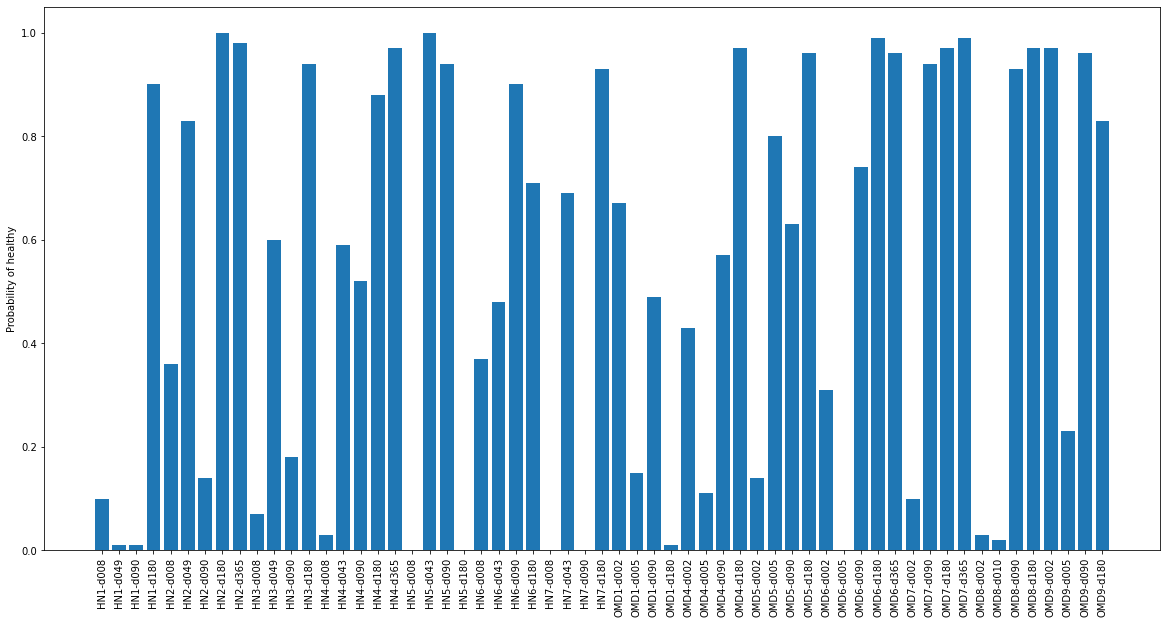

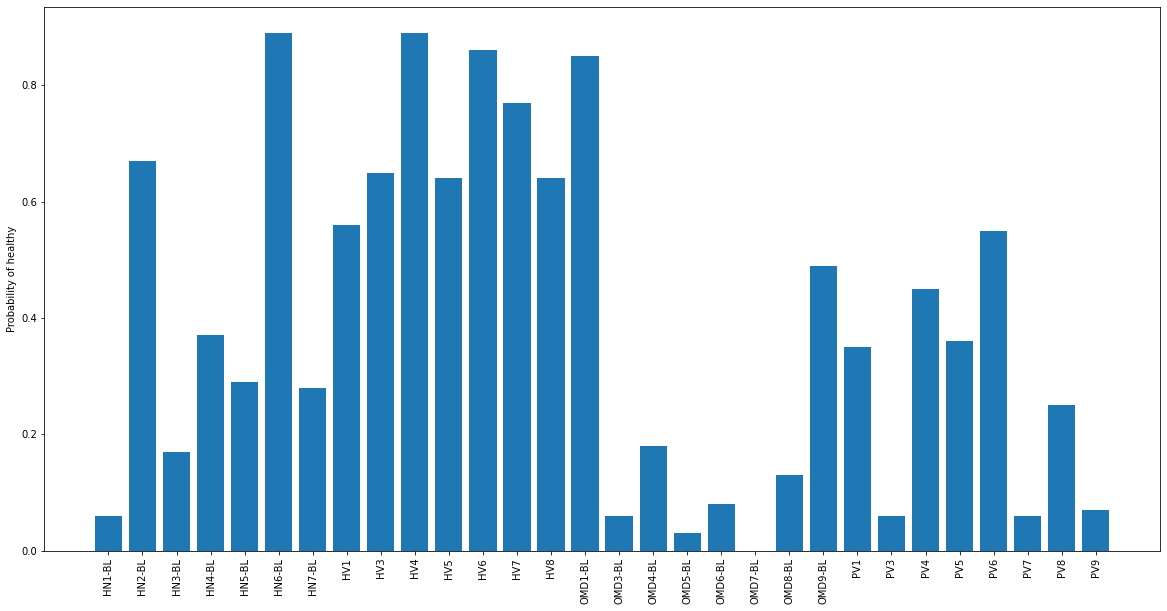

In [23]:
# handpicking some features
feat = pd.concat((uniqcounts[[70, 110, 118, 250, 280]],uniqcounts.mean(axis=1)), axis = 1)
pipeline(feat, train_samples, test_samples,  parameters = {'C': [5,6,7,8,9,10000]}, return_features = True)

best parameters {'C': 6}
Number of nonzero coeffs 20
              precision    recall  f1-score   support

           0       0.63      0.89      0.74        27
           1       0.86      0.56      0.68        32

    accuracy                           0.71        59
   macro avg       0.74      0.73      0.71        59
weighted avg       0.75      0.71      0.71        59

Int64Index([ 45,  48,  52,  54,  56, 123, 127, 129, 130, 133, 142, 156, 200,
            201, 262, 351, 352, 354, 356, 656],
           dtype='int64', name='length')


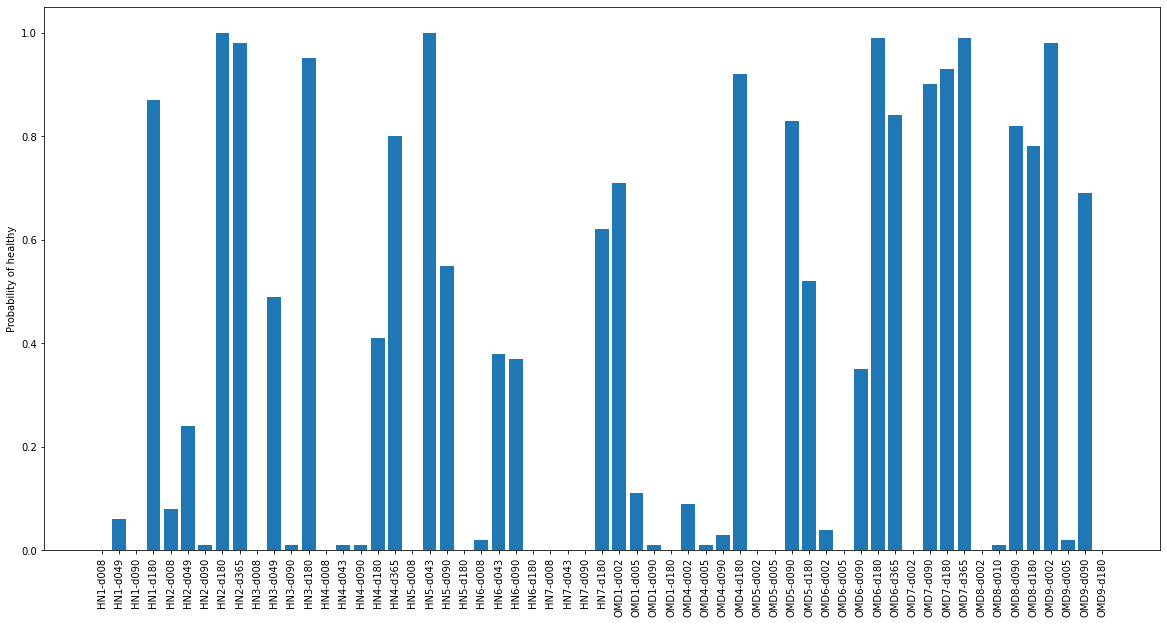

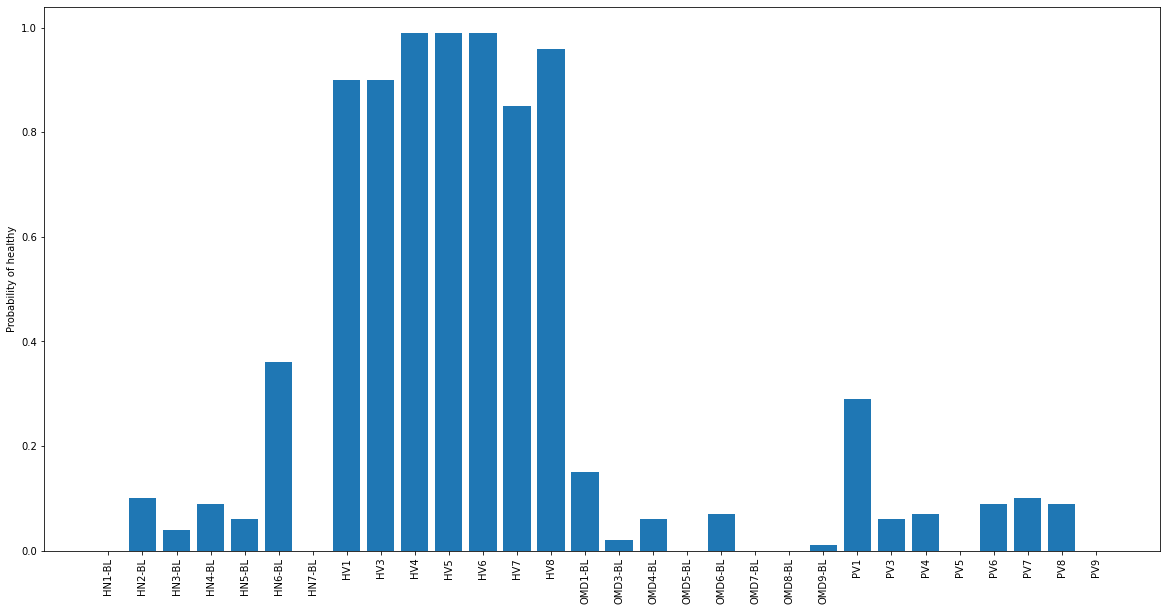

In [6]:
# only uniqcounts
columns_uniqcounts = pipeline(uniqcounts, train_samples, test_samples,  parameters = {'C': [5,6,7,8,9,10]}, return_features = True)
print(columns_uniqcounts)

best parameters {'C': 1}
Number of nonzero coeffs 7
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        27
           1       0.85      0.53      0.65        32

    accuracy                           0.69        59
   macro avg       0.73      0.71      0.69        59
weighted avg       0.74      0.69      0.69        59

Index(['glomerular_placental_clusters833_890_hg38_area',
       'placenta_cluster884_hg38_area', 'HeLa_cluster1777_hg38_depth',
       'SAEC_hg38_depth', 'melano_SOX_clusters1863_2205_hg38_depth',
       'panc_epithel_cluster1974_hg38_depth',
       'skeletal_muscle_cluster1518_hg38_depth'],
      dtype='object', name='region-set')


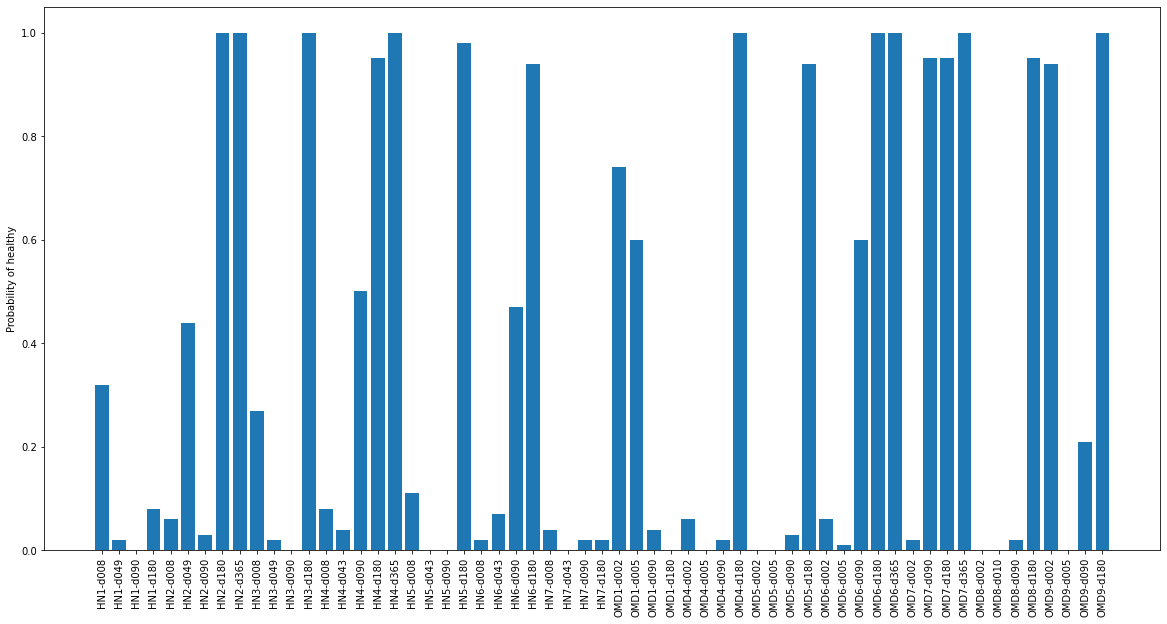

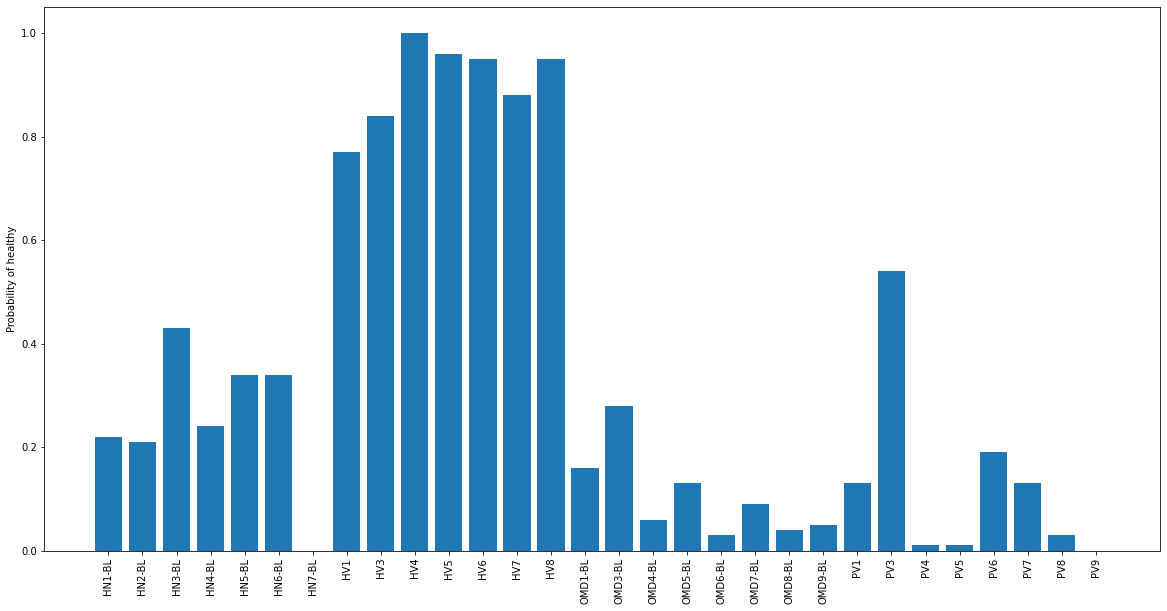

In [7]:
# only signatures
columns_sig = pipeline(sig, train_samples, test_samples, return_features = True)
print(columns_sig)

best parameters {'C': 1}
Number of nonzero coeffs 7
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        27
           1       0.85      0.53      0.65        32

    accuracy                           0.69        59
   macro avg       0.73      0.71      0.69        59
weighted avg       0.74      0.69      0.69        59



Index([                                             123,
                                                    127,
       'glomerular_placental_clusters833_890_hg38_area',
                        'placenta_cluster884_hg38_area',
              'melano_SOX_clusters1863_2205_hg38_depth',
                  'panc_epithel_cluster1974_hg38_depth',
               'skeletal_muscle_cluster1518_hg38_depth'],
      dtype='object')

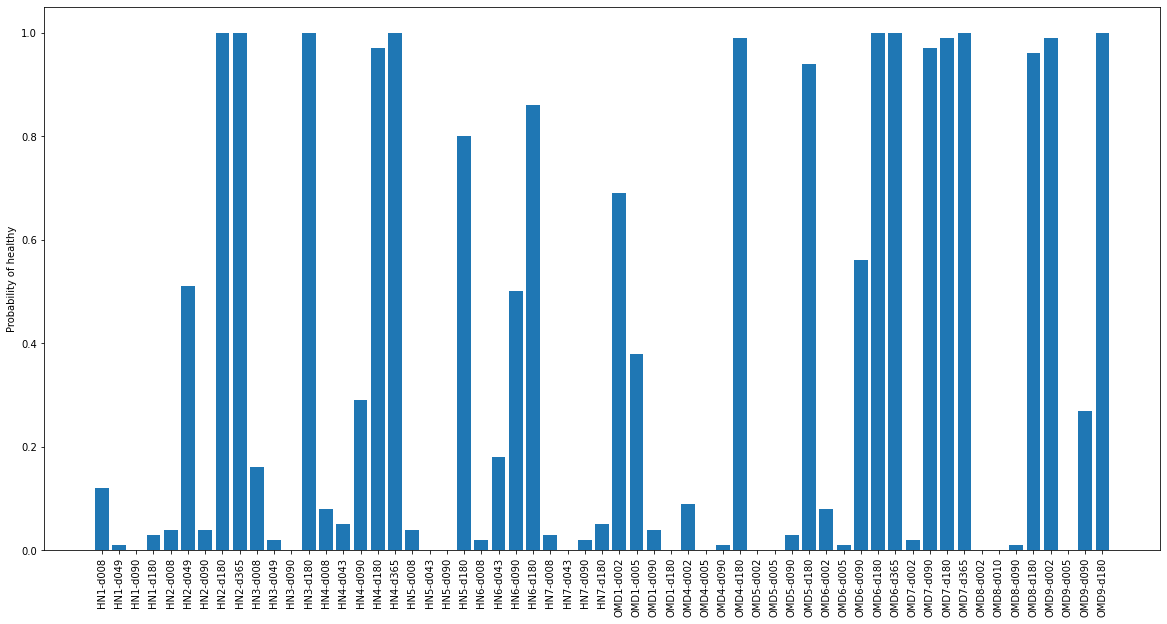

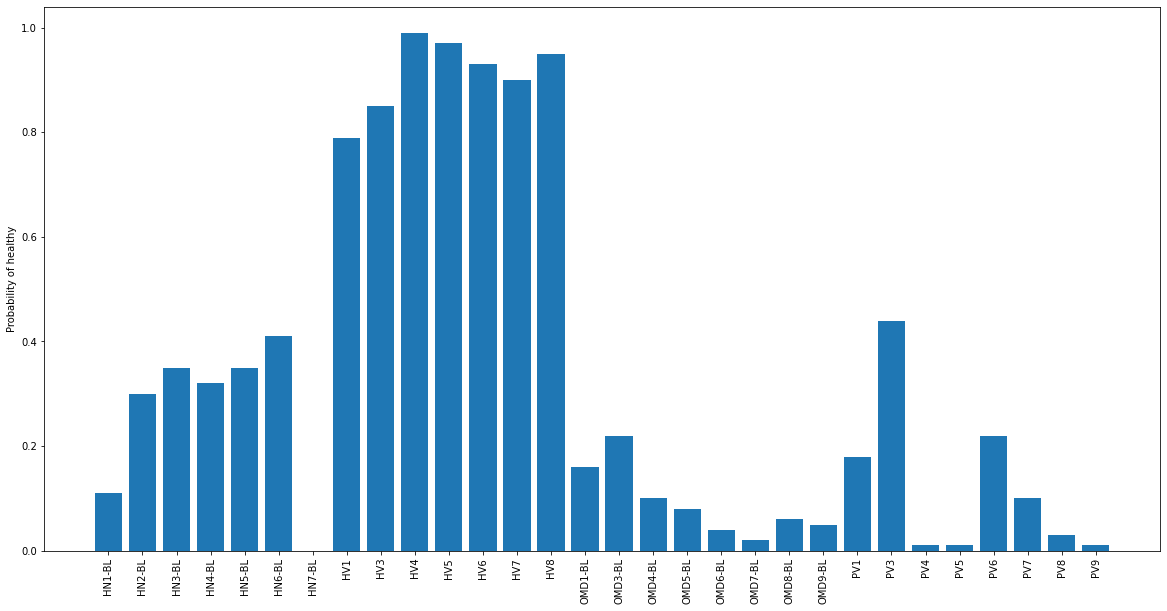

In [8]:
# combining features selected in uniqcounts and sig by the first two models
feat = pd.concat((uniqcounts[columns_uniqcounts], sig[columns_sig]), axis = 1)
pipeline(feat, train_samples, test_samples, return_features = True)

best parameters {'C': 1}
Number of nonzero coeffs 10
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        27
           1       0.85      0.53      0.65        32

    accuracy                           0.69        59
   macro avg       0.73      0.71      0.69        59
weighted avg       0.74      0.69      0.69        59



Index(['glomerular_placental_clusters833_890_hg38_area',
                        'placenta_cluster884_hg38_area',
                          'HeLa_cluster1777_hg38_depth',
              'melano_SOX_clusters1863_2205_hg38_depth',
                  'panc_epithel_cluster1974_hg38_depth',
               'skeletal_muscle_cluster1518_hg38_depth',
                                                    110,
                                                    117,
                                                    118,
                                                    121],
      dtype='object')

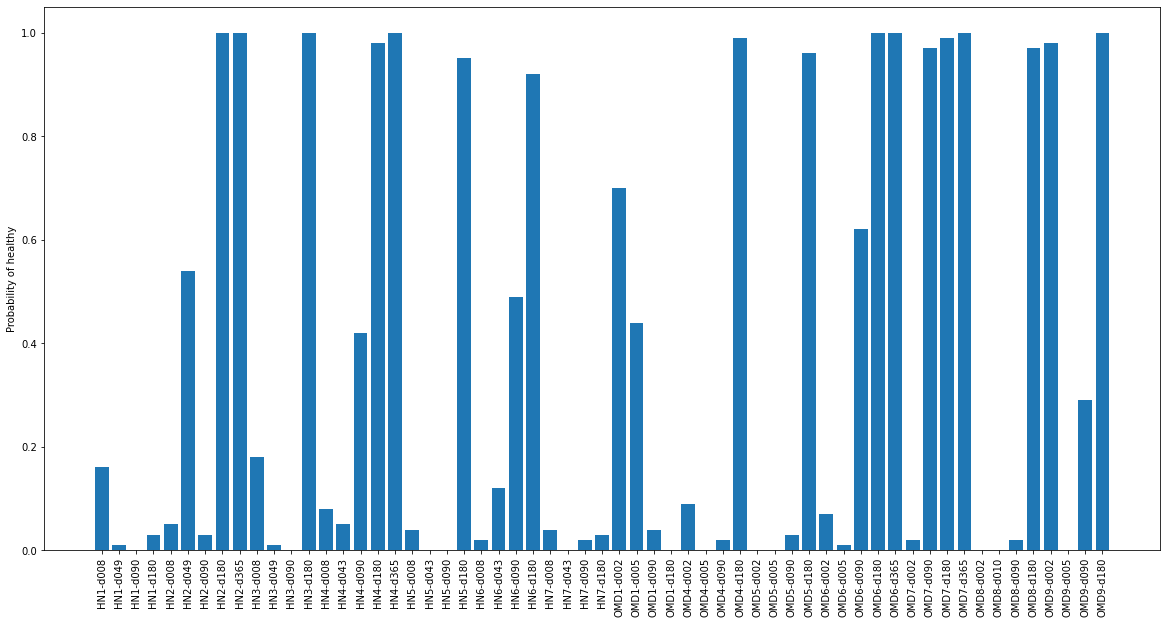

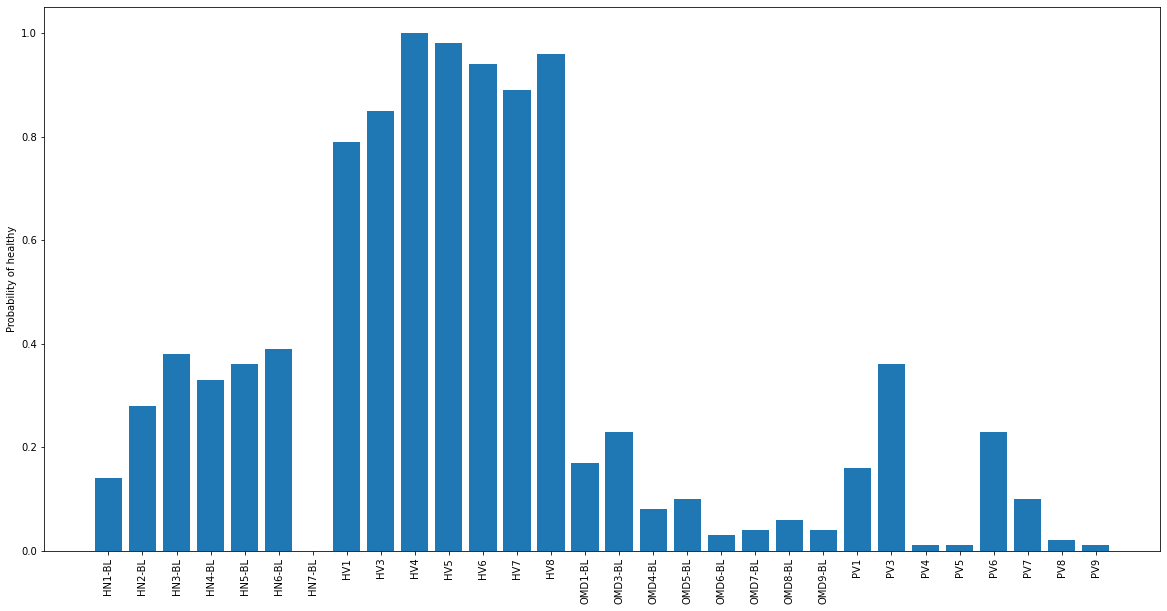

In [9]:
# signatures and uniqcounts (whole dataframes)
sig_and_uniqcounts = pd.concat([sig, uniqcounts], axis = 1)
pipeline(sig_and_uniqcounts, train_samples, test_samples,return_features = True)